In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
! cp /content/drive/MyDrive/kaggle/datasets/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d balraj98/facades-dataset
! unzip facades-dataset.zip

In [4]:
! git clone https://github.com/einstalek/DL-models-experiments.git

Cloning into 'DL-models-experiments'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 368 (delta 3), reused 7 (delta 1), pack-reused 354
Receiving objects: 100% (368/368), 12.01 MiB | 37.39 MiB/s, done.
Resolving deltas: 100% (219/219), done.


In [5]:
import sys
sys.path.append("./DL-models-experiments/")

import tqdm
import numpy as np
import torch
from torch.utils.data import DataLoader

from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib  inline

In [6]:
from models.sagan import Generator, Discriminator, train

In [7]:
! mkdir ./train
! cp ./trainA/* ./train
! cp ./testA/* ./train

In [11]:
import os
import albumentations as A
import cv2
import random
from torch.utils.data import Dataset

transform_fn = A.Compose([
    A.GaussNoise(),
    A.HorizontalFlip(),
    A.ShiftScaleRotate(rotate_limit=0, scale_limit=(0, 0.3), shift_limit=0.1, )
])


class FacadeDataset(Dataset):
    def __init__(self, img_dir, split='train', size=(256, 256)):
        self.img_dir = img_dir
        self.fps = os.listdir(img_dir)
        self.fps = [os.path.join(img_dir, x) for x in self.fps]
        self.size = size
        self.split = split

    def __getitem__(self, index):
        if self.split == 'train':
            fp = random.sample(self.fps, 1)[0]
        else:
            fp = self.fps[index]
        img = self._read(fp)

        if self.split == 'train':
            result = transform_fn(image=img)
            img = result['image']
        img = self.get_input(img)
        img = torch.from_numpy(img).float()
        return img

    def _read(self, fp):
        img = cv2.imread(fp)[..., ::-1]
        img = cv2.resize(img, self.size)
        return img

    def get_input(self, img):
        img = img / 255
        img = (img - 0.5) / 0.5
        img = np.transpose(img, (2, 0, 1))
        return img

    def __len__(self):
        return len(self.fps)

In [12]:
from collections import defaultdict

class Logger:
    def __init__(self):
        self.loss = defaultdict(list)
    
    def update(self, **loss):
        for (k, v) in loss.items():
            self.loss[k].append(v)
        
logger = Logger()

In [51]:
data = FacadeDataset("./train/")
loader = DataLoader(data, shuffle=True, batch_size=8, num_workers=8)
logger = Logger()

disc = Discriminator().cuda()
gen = Generator(64, 64).cuda()

optimizer_g = torch.optim.Adam(gen.parameters(), 3e-5, (0., 0.99))
optimizer_d = torch.optim.Adam(disc.parameters(), 5e-5, (0., 0.99))

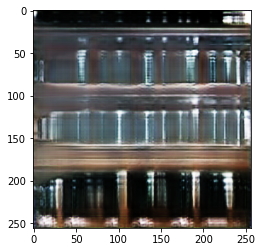

In [52]:
train(gen, disc, optimizer_g, optimizer_d, loader, logger, epochs=100)

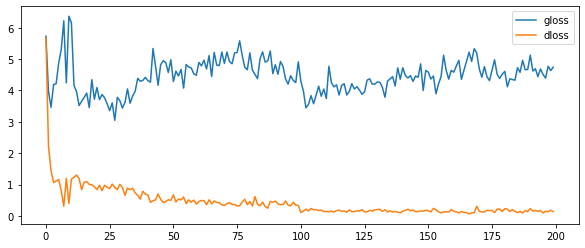

In [53]:
plt.figure(figsize=(10, 4))
for k in logger.loss:
    plt.plot(logger.loss[k], label=k)
plt.legend();

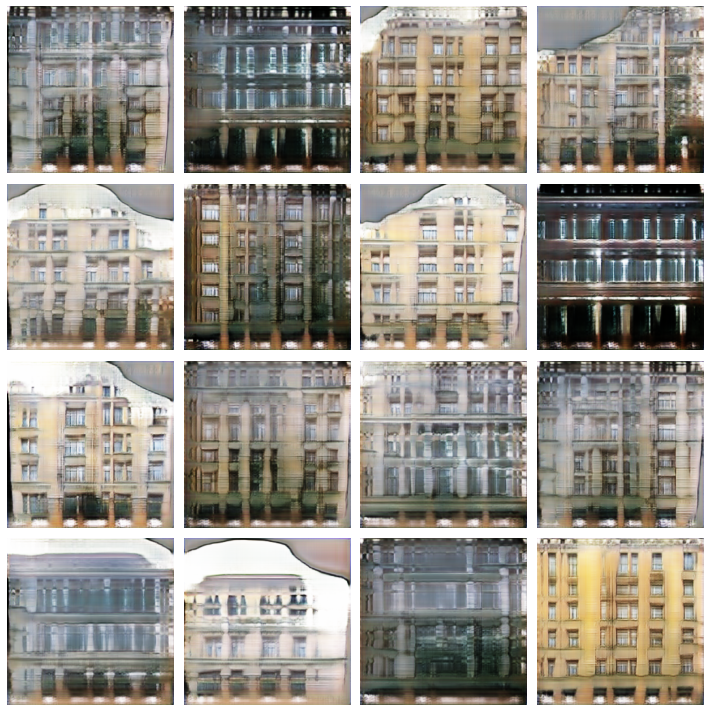

In [54]:
gen.eval()
plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i+1)
    noise = torch.randn(1, 64).to("cuda")
    x = 0.5 * gen(noise) + 0.5
    plt.imshow(x.detach().cpu().numpy()[0].transpose(1, 2, 0))
    plt.axis('off')
plt.tight_layout();